# Исследование продаж видеоигр

### Описание

Наша задача - выявить определяющие успешность игры закономерности. В нашем распоряжении исторические данные о продажах игр до 2016 года включительно, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

### План проекта:
 1. Загрузка библиотек и датасета
 2. Подготовка данных:
   - заполнение пропусков
   - удаление дубликатов
   - измнение типов данных
   - обработка "артефактных значений"
   - расчет глобальных продаж
 3. Исследовательский анализ
   - получение актуального периода
   - расчет срока появления новых и исчезновения старых платформ
   - выбор потенциально перспективных платформ
   - выявление зависимости продаж от рейтинга критиков и пользователей
   - глобальные продажи в разбивке по платформам
   - выделение самых прибыльных жанров
 4. Портрет пользователя каждого региона
   - популярные платформы
   - популярные жанры
   - влияние возрастного рейтинга
 5. Проверка гипотез
   - средние пользовательские рейтинги платформ XOne и PC 
   - Средние пользовательские рейтинги жанров Action и Sports
 6. Общие выводы    

# 1. Загрузка библиотек и датасета

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

df = pd.read_csv('/datasets/games.csv')

In [2]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## 2. Подготовка данных

Переведем названия столбцов в нижний регистр, как требуется в задании.

In [3]:
df.columns = [x.lower() for x in df.columns]

Проверим на предмет пропусков, дубликатов.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df.duplicated().sum()

0

Рассмотрим строки с пропусками в названии

In [6]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Т.к. в этих строках недостаточно информации для дальнейшего анализа - удалим их

In [7]:
df = df.drop(df[df['name'].isna()].index).reset_index()
df.drop(df.columns[0], axis=1, inplace=True)

Пропуски в столбце года заполним нереальным значением, чтобы не терять эти строки

Тип данных заменим на `int` для удобства расчетов

In [8]:
df['year_of_release'] = df['year_of_release'].fillna(9999).astype('int')

В столбце рейтинга пользователей имеются значения `tbd`, что говорит о недостаточном количестве оценок для составления рейтинга. Заменим их на пропуски

In [9]:
df['user_score'].replace(to_replace = 'tbd', value = np.nan, inplace = True)
df['user_score'] = df['user_score'].astype('float')

Посчитаем глобальные продажи и добавим в отдельный столбец

In [10]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales']

Можно сказать, что пропуски есть только в столбцах рейтингов. Они могли появиться по нескольким причинам:
  - игры могли выйти давно и данная информация просто не хранилась
  - в случае новых игр могло пройти недостаточное время для составления рейтинга
  - учитывая мультиплатформенность игры могли иметь рейтинг только на одной из платформ
    
Заполнять данные пропуски медианным/средним или иными значениями считаю нецелесообразным

# 3. Исследовательский анализ

## 3.1. Получение актуального периода

При планировании кампании на будующий год мы не нуждаемся в данных о продажах за всю историю. Найдем `актуальный период` по которому можно составить актуальное предсказание.

Построим график выхода игр в год.

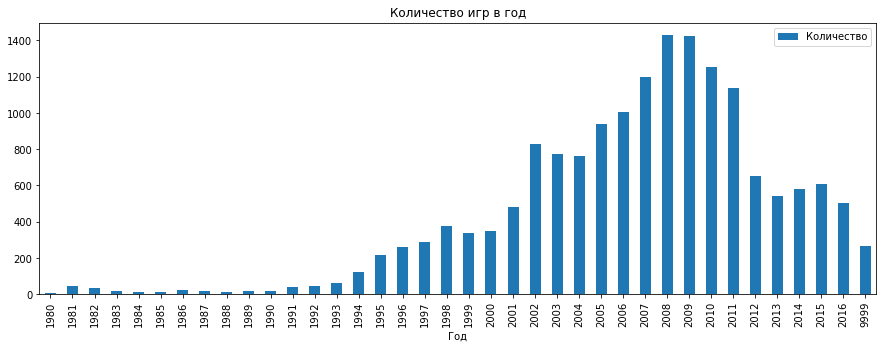

In [11]:
ax = (
    df.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').
    reset_index().rename_axis(None, axis=1).
    plot.bar(x = 'year_of_release',y= 'name', figsize = (15,5))
)

ax.legend(['Количество'])
ax.set_title('Количество игр в год')
ax.set_xlabel('Год')
plt.show()

По графику отчетливо видно, что в период с 2012 по 2016 года количество новых игр остается примерно одинаковым. Этот период возьмем как `актуальный` и в дальнейшем анализе будем использовать только его

## 3.2. Расчет срока появления новых и исчезновения старых платформ

Чтобы выявить перспективные платформы нам потребуется найти период, за который  платформы появляются и исчезают.

Сгруппируем данные по платформам и выведем суммарные продажи

In [12]:
top_sales = (
    pd.DataFrame(
        df.groupby('platform')['sum_sales'].sum().sort_values(ascending = False).head(5)
        )
    ).reset_index().rename_axis(None, axis=1)

In [13]:
top_sales

,platform,sum_sales
0,PS2,1062.33
1,X360,885.66
2,Wii,828.44
3,PS3,803.97
4,DS,746.86


Построим распределение продаж по годам для наиболее прибыльных платформ

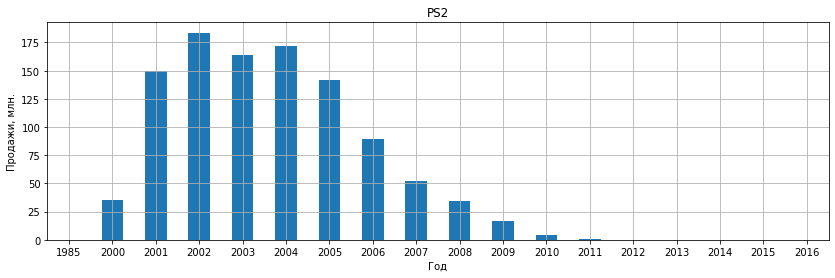

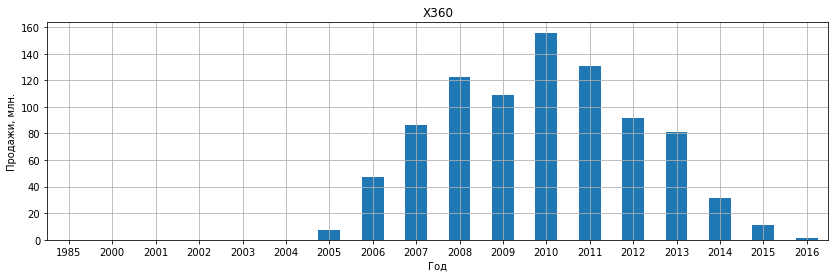

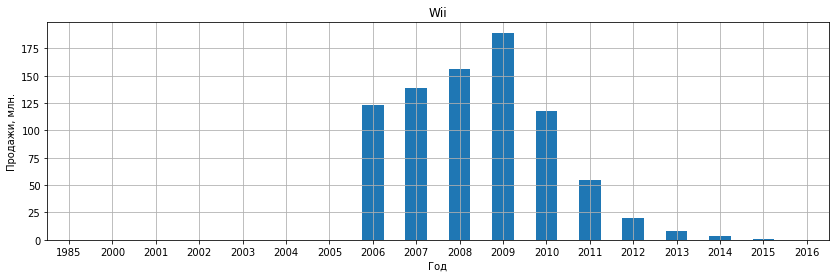

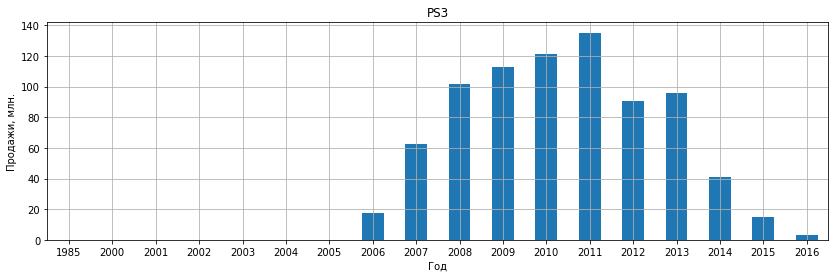

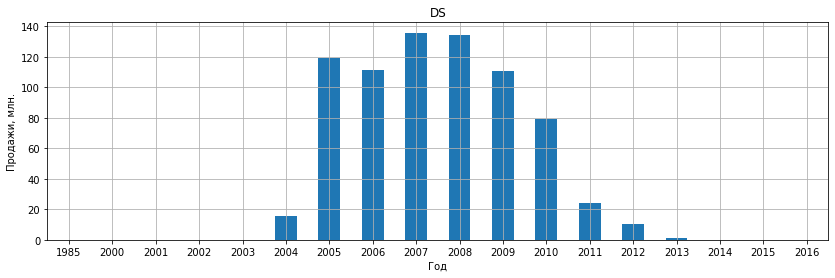

In [14]:
columns = np.array(top_sales['platform'])

for column in columns:
    ax = (
    df.
    query('platform in @top_sales.platform and year_of_release != 9999').
    pivot_table(index = 'year_of_release', columns = 'platform', values = 'sum_sales', aggfunc= 'sum').
    reset_index().
    rename_axis(None, axis=1)
).plot.bar(x = 'year_of_release',y= column , figsize = (14,4), grid = True)
    ax.set_title(column)
    ax.set_xlabel('Год')
    ax.set_ylabel('Продажи, млн.')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    ax.get_legend().remove()

Примерное время "жизни" консоли составляет от `7 до 10 лет`. Учтем эти данные в дальнейшей работе

## 3.3. Выбор потенциально перспективных платформ

Основная задача перед разработкой рекламной кампании - выбрать перспективные платформы. Для этого нам понадобятся ранее полученные данные

Создадим датасет за `актуальный период`

In [15]:
df_last = df[df['year_of_release'] >= 2012]

Выведем наиболее прибыльные платформы

In [16]:
top_sales_last = (
    pd.DataFrame(
        df_last.groupby('platform')['sum_sales'].sum().sort_values(ascending = False).head(5)
        )
    ).reset_index().rename_axis(None, axis=1)

In [17]:
top_sales_last

,platform,sum_sales
0,PS4,265.79
1,PS3,252.75
2,X360,225.44
3,3DS,186.84
4,XOne,145.05


Построим график ежегодных продаж в разбивке по самым прибыльным платформам

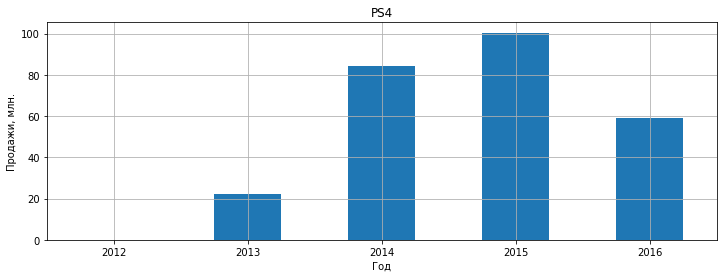

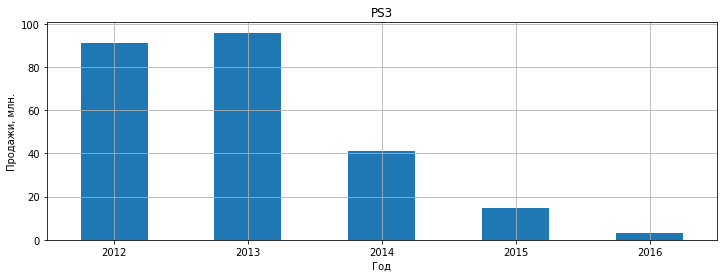

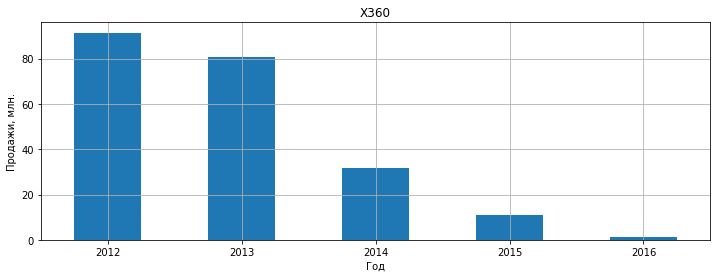

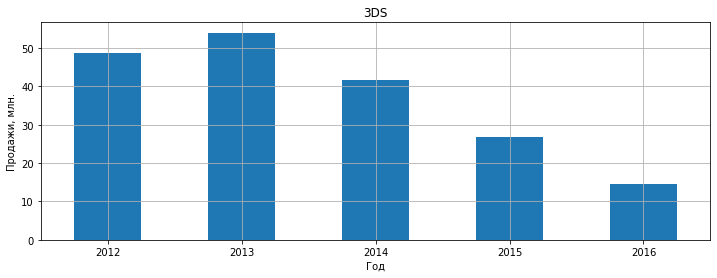

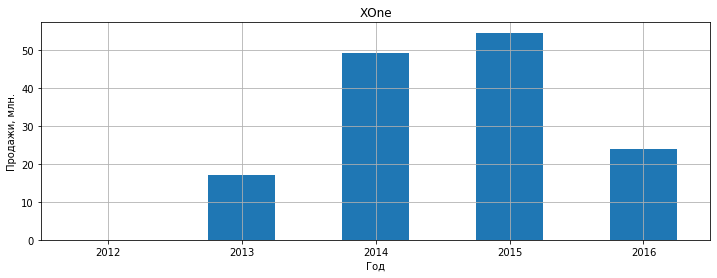

In [18]:
top_platf = np.array(top_sales_last['platform'])

for column in top_platf:
    ax = (
        df_last[df_last['year_of_release'] != 9999].query('platform in @top_platf').
        pivot_table(index = 'year_of_release', columns = 'platform', values = 'sum_sales', aggfunc= 'sum').
        reset_index().rename_axis(None, axis=1).
        plot.bar(x = 'year_of_release',y= column , figsize = (12,4), grid = True)
    )
    ax.set_xlabel('Год')
    ax.set_ylabel('Продажи, млн.')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    ax.get_legend().remove()
    ax.set_title(column)

Учитывая примерный период жизни платформы, можем выделить `PS4` и `XOne` как перспективные по нескольким признакам:
   - это новые платформы и пик продаж игр для них еще не достигнут
   - выход на пик продаж можно спрогнозировать на 2017-2018 года, т.е. продажи будут только расти

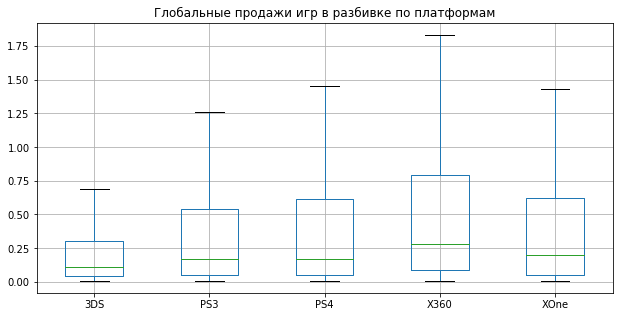

In [19]:
ax = (
    df_last[(df_last['year_of_release'] != 9999) & (df_last['platform'].isin(top_platf))].
      boxplot('sum_sales', by = 'platform', figsize = (10,5), showfliers=False, grid = True)
     )
ax.set_title('Глобальные продажи игр в разбивке по платформам')
ax.set_xlabel('')
plt.suptitle('')
plt.show()

- Самые высокие продажи у платформы `X360`, одной из причин которых является ее долго нахождение на рынке. Данную консоль коректнее сравивать с `PS3`
- Продажи для консолей `PS4` и `XOne` находятся на одном уровне, причем они довольно близки к `X360`. Учитывая их недавнее появление на рынке можно предположить, что их продажи обгонят `X360`
- Средние продажи довольно близки для всех консолей

## 3.4. Выявление зависимости продаж от рейтинга критиков и пользователей

Построим диаграмму рассеяния и рассчитаем корреляцию между отзывами и продажами

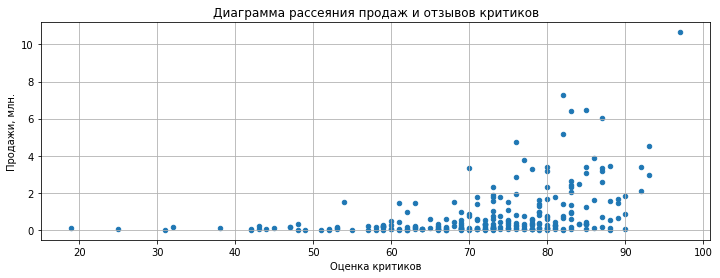

Корреляция отзывов критиков и глобальных продаж составляет: 0.4058867746520127


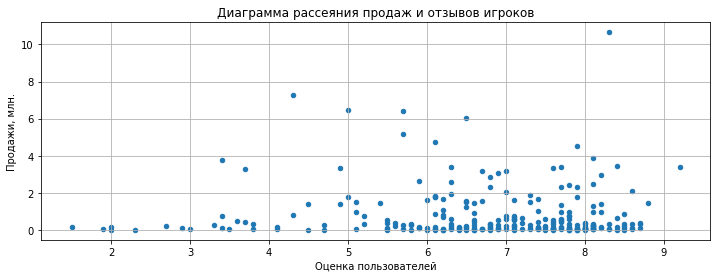

Корреляция отзывов критиков и глобальных продаж составляет: -0.03126053686666918


In [30]:
for column, name, title in zip(
    ['critic_score', 'user_score'], 
    ['Оценка критиков', 'Оценка пользователей'], 
    ['Диаграмма рассеяния продаж и отзывов критиков','Диаграмма рассеяния продаж и отзывов игроков']
):
    df_last[df_last['platform'] == 'PS4'].plot(x = column, y = 'sum_sales', kind = 'scatter', grid = True, figsize = (12, 4))
    plt.title(title)
    plt.xlabel(name)
    plt.ylabel('Продажи, млн.')
    plt.show()

    print(
        'Корреляция отзывов критиков и глобальных продаж составляет:',
        df_last[df_last['platform'] == 'PS4'][column].corr(df_last[df_last['platform'] == 'PS4']['sum_sales'])
    )

Гораздо большее влияние на продажи оказывают `отзывы критиков`. Для меня это крайне удивительный вывод, т.к. ни я, ни кто либо из моих знакомых при покупке игры не руководствовался мнением критиков

## 3.5. Выделение самых прибыльных жанров

Построим сводную таблицу по платформам и суммарным продажам

In [21]:
genre_sales = (
    pd.DataFrame(
        df_last.groupby('genre')['sum_sales'].sum().sort_values(ascending = False)
        )
    ).reset_index().rename_axis(None, axis=1)

In [22]:
genre_sales

,genre,sum_sales
0,Action,415.25
1,Shooter,277.78
2,Role-Playing,181.23
3,Sports,177.93
4,Misc,88.30
5,Platform,57.56
6,Racing,51.60
7,Fighting,44.40
8,Simulation,34.78
9,Adventure,30.76


Жанры `Action` и `Shooter` являются наиболее зрелищными, динамичными и крупнобюджетными. Вполне логично что они лидируют по продажам

# 4. Портрет пользователя каждого региона

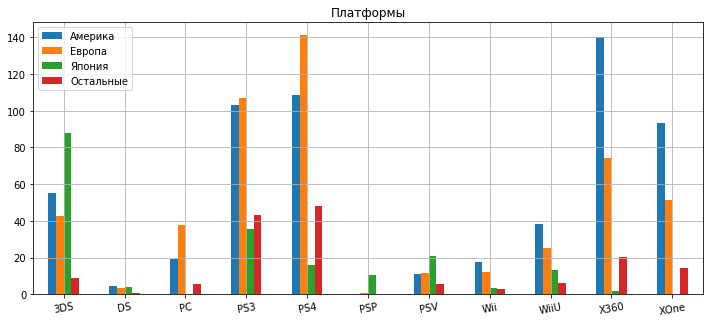

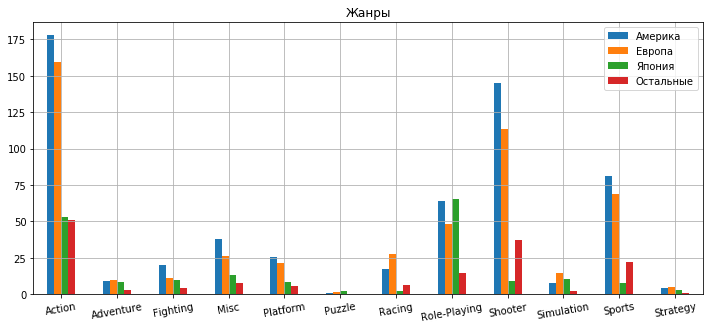

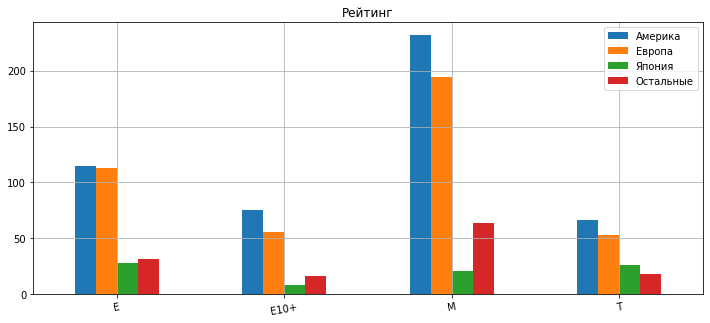

In [23]:
for column,name in zip(['platform', 'genre', 'rating'], ['Платформы','Жанры','Рейтинг']):
    ax = (
    df_last[df_last['year_of_release'] != 9999].groupby(column)[df_last.columns[4:8]].agg(['sum']).
    plot.bar(grid = True, figsize = (12,5))
    )
    ax.legend(['Америка', 'Европа', 'Япония', 'Остальные'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 10)
    ax.set_xlabel('')
    ax.set_title(name)
    plt.show()

Консоли в разных регионах:
   - в *Америке* наиболее популярны консоли серии `X-Box`
   - `PlayStaytion 3 и 4` особенно популярны в *Евпропе*
   - в *Японии* большую популярность имеет `Nintendo 3DS`, а так же портативная серия `PlayStation`
   - в *остальных регионах* в основном популярны `PlayStation` и `X-Box
   
Жанры в разных регионах:
   - в *Америке* - `Action`, `Shooter`, `Sports`
   - в *Европе* - `Action`, `Shooter`, `Sports`
   - в *Японии* - `Action`, `Role-Playing`
   - в *остальных регионах* - `Action`, `Shooter`, `Sports`
    
Возрастные рейтинги:
   - во всех регионах, кроме *Японии*, игры рейтинга `М` преобладают
   - в *Японии* все рейтинги имеют популярность

# 5. Проверка гипотез

## 5.1. Средние пользовательские рейтинги платформ XOne и PC 

Для проверки гипотез нам понадобится датасет без пропусков

In [24]:
hippo = df_last.dropna()

Для удобства выделим датасеты для платформ PC и XOne

In [25]:
xbox_one = hippo[hippo['platform'] == 'XOne']
pc = hippo[hippo['platform'] == 'PC']

Сформулируем нулевую гипотезу: `Средние пользовательские рейтинги платформ PC и XOne равны`  
Альтернативная гипотеза: `Средние пользовательские рейтинги платформ PC и XOne не равны`  

In [26]:
results = st.ttest_ind(
    xbox_one['user_score'], 
    pc['user_score'],
    equal_var = False)
print('p-значение:', results.pvalue)

alpha = .05

if ((results.pvalue) < alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Принимаем нулевую гипотезу и отвергаем альтернативную") 

p-значение: 0.5640239555666027
Принимаем нулевую гипотезу и отвергаем альтернативную


## 5.2. Средние пользовательские рейтинги жанров Action и Sports

In [27]:
action = hippo[hippo['genre'] == 'Action']
sport = hippo[hippo['genre'] == 'Sports']

Сформулируем нулевую гипотезу: `Средние пользовательские рейтинги жанров Action и Sports равны`  
Альтернативная гипотеза: `Средние пользовательские рейтинги жанров Action и Sports не равны` 

In [28]:
results = st.ttest_ind(
    action['user_score'], 
    sport['user_score'],
    equal_var = False)
print('p-значение:', results.pvalue)

alpha = .05

if ((results.pvalue) < alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Принимаем нулевую гипотезу и отвергаем альтернативную") 

p-значение: 2.102852898651465e-09
Отвергаем нулевую гипотезу в пользу альтернативной


# 6. Общие выводы

Была проведена работа по предобработке данных:
  - обработка пропусков
  - добавление переменных
  - изменение типов данных
  
Получены следующие результаты исследовательского анализа:
  - с 2009 года количество новых игр стало уменьшаться, вплоть до 2012 года. С 2012 по 2016 год выходило около 600 игр ежегодно. `Года с 2012 по 2016 составляют актуальный период`, на которым можно опираться при составлении прогнозов на следующий год
  - с момента появления платформы до ее ухода с рынка проходит `7-10 лет`
  - по данным актуального периода были выбраны перспективные платформы, а именно `PS4` и `XOne`
  - средние продажи `PS4` и `XOne` очень близки, можно предположить дальнейшее усиление конкуренции данных консолей
  - самые популярны жанры `Action`,`Shooter`,`Role-Playing`,`Sports`. Заметно лидирует в продажах жанр `Action` (415.25 млн.)

Составлен примерный портрет пользователей разных регионов:  
   1. Северная Америка:
      - наиболее популярны консоли серии `XBox`
      - самые популярные жанры это `Action`, `Shooter`, `Sports`
      - рейтинги  `Е` и `М` самые популярны
   2. Европа:
      - самая популярная консоль `PS4`
      - самые популярные жанры и рейтинги схожи с `Северной Америкой`
   3. Япония:
      - самая популярная консоль `3DS`, а так же популярны все консолии серии `PlayStation`
      - популярные жанры `Role-Playing` и `Action`
      - популярны все рейтинги, кроме `M`
      
Проведено гипотезное тестирование:
  - вероятность совпадения средних пользовательских рейтингов платформ `XOne` и `PC` очень велика, что может говорить о кросплатформенности, т.е. одинаковых играх на этих двух платформах
  - вероятность совпадения средних пользовательских рейтингов жанров `Action` и `Sports` практически равна нулю. Учитывая огромную разницу в продажах по этим жанрам было бы странно ожидать их совпадения.
  
**Прогнозы на будущий год:**
  - ближайшие несколько лет продажи игр для консолей `PS4` и `XOne` будут расти
  - будет целесообразно сделать ставку на консоли `PS4` и `XOne`, возможно, для каждого региона стоит выбрать приоритетный вариант
  - самыми перспективными жанрами являются `Action` и `Shooter`, но в случае `Японии` не стоит забывать про `Role-Playing`
  - т.к. больше всего продается игр с рейтингом `M`, то стоит сделать упор на взрослую аудиторию